# FCC Calorimeter Performance Studies Workflow

## Overview

This tutorial will teach you how to:

* **simulate** the single particle response of the calorimeter detector system
* **reconstruct** physics object from raw signals
* produce **plots** of energy resolutions and other quantities.

First, make sure your setup of the FCC software is working. 
You can check that the command to run jobs in the Gaudi framework is available on the command line:

In [1]:
!which fccrun

/cvmfs/fcc.cern.ch/sw/releases/fccsw/linux-centos7-x86_64/gcc-8.3.0/fccsw-0.11-qqmlmzumogldsqoegt4ihhel4xnt62yw/scripts/fccrun


If you don't see a valid path like `/usr/local/bin/fccrun`  you should consult [the documentation page on FCCSW setup](https://github.com/vvolkl/fcc-tutorials/blob/master/FccSoftwareGettingStarted.md)

## Using the DD4hep detector model in FCC Software.

The Geant4 geometry is used for the full simulation of the detector is not written directly, but generated using the DD4hep library.
The detector description in this library consists of two parts:
A compiled C++ library that constructs the geometry, and a set of xml files that contain parameters that can are parsed by the library at runtime and make the detector geometry (somewhat) configurable.
In the framework, the geometry is available to all components via the service `GeoSvc`.
One of the simplest jobs is to write the geometry to a `.gdml` file:

In [2]:
%%writefile dumpGeo_fccee.py

import os
from Gaudi.Configuration import *
from Configurables import GeoSvc
geoservice = GeoSvc("GeoSvc")
geoservice.detectors=[
  os.path.join(os.environ.get("FCC_DETECTORS", ""), 'share/FCCSW/Detector/DetFCCeeIDEA/compact/FCCee_DectMaster.xml'),
                    ]

from Configurables import SimG4Svc
geantservice = SimG4Svc("SimG4Svc")

from Configurables import GeoToGdmlDumpSvc
geodumpservice = GeoToGdmlDumpSvc("GeoDump") 
geodumpservice.gdml="FCCee_IDEA.gdml"

from Configurables import ApplicationMgr
ApplicationMgr( TopAlg = [], 
                EvtSel = 'NONE',
                EvtMax   = 1,
                # order is important, as GeoSvc is needed by SimG4Svc
                ExtSvc = [geoservice, geantservice, geodumpservice],
                OutputLevel=INFO
 )


Writing dumpGeo_fccee.py


A job with this configuration can be executed with 

In [3]:
!fccrun dumpGeo_fccee.py

 

ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v32r0)
                                          running on 74d76f9a8ce0 on Wed Oct  2 18:24:47 2019

**************************************************************
 Geant4 version Name: geant4-10-05-patch-01 [MT]   (17-April-2019)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

ApplicationMgr       INFO Application Manager Configured successfully
PersistencyIO    INFO  +++ Set Streamer to dd4hep::OpaqueDataBlock
GeoSvc               INFO loading geometry from file:  '/cvmfs/fcc.cern.ch/sw/releases/fccsw/linux-centos7-x86_64/gcc-8.3.0/fccsw-0.11-qqmlmzumogldsqoe

RndmGenSvc.Engine    INFO Generator engine type:CLHEP::RanluxEngine
RndmGenSvc.Engine    INFO Current Seed:1234567 Luxury:3
RndmGenSvc           INFO Using Random engine:HepRndm::Engine<CLHEP::RanluxEngine>
<<< Geant4 Physics List simulation engine: FTFP_BERT 2.0

Geant4Converter  INFO  +++  Successfully converted geometry to Geant4.
DD4hepVolumeManager INFO  **** running plugin DD4hepVolumeManager ! 
VolumeManager    INFO   - populating volume ids - be patient ...
VolumeManager    INFO   - populating volume ids - done. 348 nodes.
VolumeManager    INFO  +++ Volume manager populated and loaded.

 FTFP_BERT : new threshold between BERT and FTFP is over the interval 
 for pions :   3 to 12 GeV
 for kaons :   3 to 12 GeV
 for proton :  3 to 12 GeV
 for neutron : 3 to 12 GeV

### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0
even though it appears in the current tracking world.
Default cuts are used for this region.
even though it appears in the current tracking

Note the printout of the GeoSvc and make sure the information is as expected. If there is something unclear or missing make sure to open an [issue](https://github.com/HEP-FCC/FCCSW/issues)!
Take a look at the resulting gdml file. Although it is text-based it is not really human-readable for a geometry of this size, but you can check the number of lines and volume names if you are familiar with the geometry.

In [4]:
!tail FCCee_IDEA.gdml

        <volumeref ref="LumiCalBackShield_envelope0x4488f00"/>
      </physvol>
    </volume>
  </structure>

  <setup name="Default" version="1.0">
    <world ref="world_volume0x44890d0"/>
  </setup>

</gdml>


In [5]:
# count occurences of "physvol"
!grep -c "<physvol" FCCee_IDEA.gdml

717


## Running Geant4 within the FCC Software Framework

To run Geant4, a number of additional components are required, foremost the `SimG4Alg` and `SimG4Svc`.
The simplest way to generate a particle to simulate is to use one of the particle guns (`GenAlg` with the `MomentumRangeParticleGun` tool for example).
This algorithm produces a particles with energies from a flat probability distribution in HepMC format.
To use them as input they first need to be converted to the FCC event data model (`HepMCToEDMConverter`) and piped into the Geant4 interface via the `SimG4PrimariesFromEdmTool`.

A configuration that runs all of this is distributed with FCCSW and can be run with the following command:

(This simulates the response of 5GeV electrons which makes for modest shower sizes and should produce 500 events in around 2 minutes)


In [6]:
! FCC_DETECTORS=$FCCSWBASEDIR/share/FCCSW; time fccrun  $FCCSWBASEDIR/share/FCCSW/RecFCCeeCalorimeter/options/runCaloSim.py --filename fccee_idea_LAr_pgun.root -n 500 

 -->  SimG4Alg  -->  CreateECalBarrelCellsStep1  -->  positionsBarrelEcal  -->  ReSegmentationEcal  -->  CreateECalBarrelCells  -->  out  

ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v32r0)
                                          running on 74d76f9a8ce0 on Wed Oct  2 18:24:53 2019

**************************************************************
 Geant4 version Name: geant4-10-05-patch-01 [MT]   (17-April-2019)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

ApplicationMgr       INFO Application Manager Configured successfully
GeoSvc               INFO loading geometry from file:  '/cvmfs/fcc.cern.ch/sw/rel

EventLoopMgr      WARNING Unable to locate service "EventSelector" 
EventLoopMgr      WARNING No events will be processed from external input.
HistogramPersis...WARNING Histograms saving not required.
ApplicationMgr       INFO Application Manager Initialized successfully
ApplicationMgr       INFO Application Manager Started successfully
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.179835 2.70519
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.114991 6.17428
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.220239 3.91573
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.164216 4.80345
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.190301 3.86074
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.111846 1.01884
SimG4Alg.SimG4S...  DEBUG 

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.100905 0.0948224
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.238114 5.85915
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.284781 4.32627
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0431594 3.81034
SimG4Alg.SimG4S...  DE

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0647449 1.62921
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.113744 5.83281
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.169475 1.76877
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.290207 4.31752
SimG4Alg.SimG4S...  DEBUG

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.12325 0.359601
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.187103 6.24427
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0156603 0.0460174
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.279341 0.230339
SimG4Alg.SimG4S...  D

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.160741 1.703
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0015732 3.45215
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.281389 2.71335
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.260692 0.80853
SimG4Alg.SimG4S...  DEBUG pa

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.157804 1.88492
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.156148 4.39939
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.139851 4.04228
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0897213 3.32644
SimG4Alg.SimG4S...  DEBU

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.158336 4.2778
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.2792 2.89888
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.298217 2.82621
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0801498 3.309
SimG4Alg.SimG4S...  DEBUG part

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0782415 2.00509
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.216817 2.45824
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0446461 4.39106
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.229271 5.22589
SimG4Alg.SimG4S...  DEBU

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.103865 4.16377
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0741206 2.79568
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0284744 3.56023
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.101818 0.918487
SimG4Alg.SimG4S...  DEB

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.100861 4.57293
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.203225 3.51324
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.125831 2.33176
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.253585 3.31518
SimG4Alg.SimG4S...  DEBUG 

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0484446 3.15256
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0697201 2.26703
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.139896 3.38065
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.287021 1.40958
SimG4Alg.SimG4S...  DEBU

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.290954 3.07672
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.163826 1.61083
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0164906 1.25103
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0276111 5.67392
SimG4Alg.SimG4S...  DEB

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.227898 3.79013
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0994922 5.68017
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.0573802 4.70919
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.228937 3.19077
SimG4Alg.SimG4S...  DEBU

SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = -0.0493293 5.25161
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.212074 1.8123
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.271188 1.67818
SimG4Alg.SimG4S...  DEBUG particle definition 0x5b6c800 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 5000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0.290538 4.56277
SimG4Alg.SimG4S...  DEBUG p


real	3m32.493s
user	3m22.479s
sys	0m1.268s


The output of this job is `fccee_idea_LAr_pgun.root`, a ROOT file containing the simulation products of 500 single particle events (5 Gev e-) in the FCC event data model.
Check for example that the distribution of the input particles is as you expect:

Welcome to JupyROOT 6.18/04


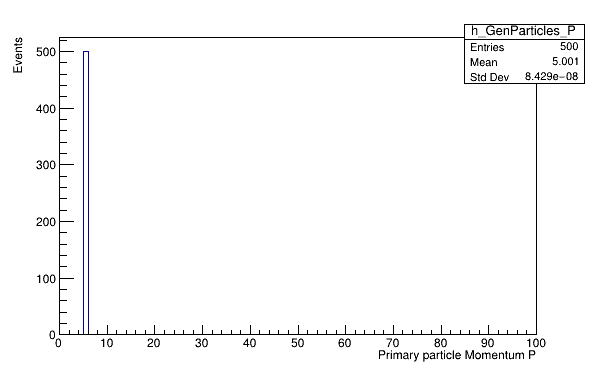

In [7]:
import ROOT
f = ROOT.TFile("fccee_idea_LAr_pgun.root")
events = f.Get("events")
c = ROOT.TCanvas("canvas1", "",600, 400)
h = ROOT.TH1F("h_GenParticles_P", ";Primary particle Momentum P; Events", 100, 0 ,100)
events.Draw("sqrt(pow(GenParticles.core.p4.px,2) + pow(GenParticles.core.p4.py,2) +pow(GenParticles.core.p4.pz,2))>>h_GenParticles_P")
c.Draw()


The exact position of the energy deposit is available too (Note that this collection, which is MCTruth-level information is not usually saved on disk to save space):

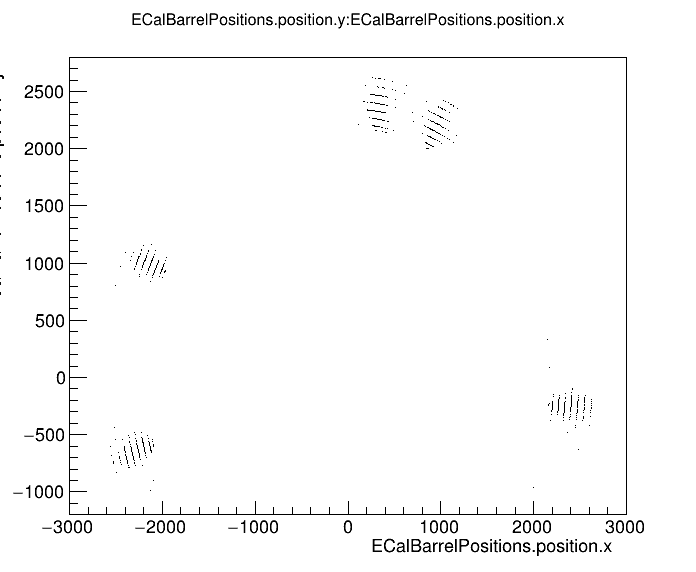

In [8]:
import ROOT
f = ROOT.TFile("fccee_idea_LAr_pgun.root")
events = f.Get("events")

c = ROOT.TCanvas("c_ECalBarrelPositions_xy", "", 700, 600)
# draw hits for first five events
events.Draw("ECalBarrelPositions.position.y:ECalBarrelPositions.position.x", "", "", 5, 0)
c.Draw()

### Obtaining and Plotting the Energy Resolution

Now that the detector response is simulated, it is time to reconstruct the signals. FCCSW includes another configuration to run a Sliding Window reconstruction:

In [9]:
!FCC_DETECTORS=$FCCSWBASEDIR/share/FCCSW; fccrun $FCCSWBASEDIR/share/FCCSW/RecFCCeeCalorimeter/options/runFullCaloSystem_ReconstructionSW_noiseFromFile.py -v --input fccee_idea_LAr_pgun.root -n 100 --noiseFileName root://eospublic.cern.ch//eos/experiment/fcc/ee/simulation/NoiseConstants/elecNoise_ecalBarrelFCCee_50Ohm_traces1_4shieldWidth.root --filename output_allCalo_reco_noise.root

 -->  PodioReader  -->  CreateEmptyCaloCells  -->  CreateECalBarrelCells  -->  CreateClusters  -->  out  

JobOptionsSvc       DEBUG Service base class initialized successfully
MessageSvc          DEBUG Service base class initialized successfully
ApplicationMgr      DEBUG Getting my own properties
ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v32r0)
                                          running on 74d76f9a8ce0 on Wed Oct  2 18:28:30 2019
ApplicationMgr    VERBOSE declared service EvtDataSvc/EventDataSvc
ApplicationMgr    VERBOSE declared service DetDataSvc/DetectorDataSvc
ApplicationMgr    VERBOSE declared service HistogramSvc/HistogramDataSvc
ApplicationMgr    VERBOSE declared service HbookCnv::PersSvc/HbookHistSvc
ApplicationMgr    VERBOSE declared service RootHistCnv::PersSvc/RootHistSvc
ApplicationMgr    VERBOSE declared service EvtPersistencySvc/EventPersistencySvc
ApplicationMgr    VERBOSE declared servic

CreateECalBarre...   INFO Opening the file with noise constants:  'noiseFileName':root://eospublic.cern.ch//eos/experiment/fcc/ee/simulation/NoiseConstants/elecNoise_ecalBarrelFCCee_50Ohm_traces1_4shieldWidth.root
CreateECalBarre...VERBOSE ServiceLocatorHelper::service: found service ToolSvc
ToolSvc           VERBOSE Created tool TubeLayerPhiEtaCaloTool/CreateECalBarrelCells.EcalBarrelGeo
CreateECalBarre...VERBOSE ServiceLocatorHelper::service: found service GeoSvc
CreateECalBarre...   INFO Readout:  'readoutName':ECalBarrelPhiEta
CreateECalBarre...   INFO Number of active layers 8
CreateECalBarre...   INFO FCCSWGridPhiEta: size in eta 0.01 , bins in phi 704
CreateECalBarre...   INFO FCCSWGridPhiEta: offset in eta -1.68024 , offset in phi -3.13713
AlgExecStateSvc     DEBUG preInit: will add Alg CreateECalBarrelCells later
CreateECalBarre...VERBOSE ServiceLocatorHelper::service: found service ToolSvc
ToolSvc           VERBOSE Created tool CalibrateCaloHitsTool/CreateECalBarrelCells.Cali

out               VERBOSE ServiceLocatorHelper::service: found service AlgExecStateSvc
AlgExecStateSvc     DEBUG preInit: will add Alg out later
out                 DEBUG input handles: 0
out                 DEBUG output handles: 0
out                 DEBUG Data Deps for out
EventLoopMgr      WARNING Unable to locate service "EventSelector" 
EventLoopMgr      WARNING No events will be processed from external input.
HistogramDataSvc    DEBUG Service base class initialized successfully
HistogramDataSvc  VERBOSE ServiceLocatorHelper::service: found service IncidentSvc
HistogramPersis...  DEBUG Service base class initialized successfully
HistogramPersis...WARNING Histograms saving not required.
HistogramDataSvc  VERBOSE ServiceLocatorHelper::service: found service HistogramPersistencySvc
ApplicationMgr       INFO Application Manager Initialized successfully
ServiceManager      DEBUG Starting service EventDataSvc
ServiceManager      DEBUG Starting service GeoSvc
ServiceManager      DEBUG St

IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read GenParticles with id 1
CreateClusters      DEBUG Pre-clusters size before duplicates removal: 3
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: 0.198786 phi: 1.18724 x: 0.374218 y: 0.927341 z: 0.200098 energy: 5.32171 contains: 0 cells
out                 DEBUG Filling DataTree ..
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read GenPa

CreateClusters      DEBUG Pre-clusters size before duplicates removal: 7
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: -0.133715 phi: -2.21748 x: -0.602547 y: -0.798084 z: -0.134114 energy: 5.53405 contains: 0 cells
out                 DEBUG Filling DataTree ..
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read GenParticles with id 1
CreateClusters      DEBUG Pre-clusters size before duplicates removal: 8
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: -0.0497418 phi: -0.916659 x: 0.608475 y: -0.793573 z: -0.0497623 energy: 5.49799 contains: 0 cells
out                 DEBUG Filling DataTree

CreateClusters      DEBUG Pre-clusters size before duplicates removal: 6
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: 0.223566 phi: 0.799159 x: 0.69731 y: 0.71677 z: 0.225433 energy: 5.30316 contains: 0 cells
out                 DEBUG Filling DataTree ..
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read GenParticles with id 1
CreateClusters      DEBUG Pre-clusters size before duplicates removal: 5
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: -0.203411 phi: 0.435716 x: 0.906568 y: 0.42206 z: -0.204817 energy: 6.11834 contains: 0 cells
out                 DEBUG Filling DataTree ..
Inciden

IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read GenParticles with id 1
CreateClusters      DEBUG Pre-clusters size before duplicates removal: 9
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: -0.140652 phi: -1.41666 x: 0.153524 y: -0.988145 z: -0.141116 energy: 4.94942 contains: 0 cells
out                 DEBUG Filling DataTree ..
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read G

CreateClusters      DEBUG Pre-clusters size before duplicates removal: 7
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: 0.253734 phi: -2.75486 x: -0.926144 y: -0.377169 z: 0.256466 energy: 5.78529 contains: 0 cells
out                 DEBUG Filling DataTree ..
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read GenParticles with id 1
CreateClusters      DEBUG Pre-clusters size before duplicates removal: 12
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: 0.206444 phi: -0.893593 x: 0.626616 y: -0.779328 z: 0.207913 energy: 5.22788 contains: 0 cells
out                 DEBUG Filling DataTree ..
I

IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read GenParticles with id 1
CreateClusters      DEBUG Pre-clusters size before duplicates removal: 9
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: -0.238788 phi: -0.398423 x: 0.921674 y: -0.387966 z: -0.241064 energy: 6.1068 contains: 0 cells
out                 DEBUG Filling DataTree ..
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read G

CreateClusters      DEBUG Pre-clusters size before duplicates removal: 4
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: -0.117353 phi: 2.2925 x: -0.660664 y: 0.750681 z: -0.117623 energy: 5.82503 contains: 0 cells
out                 DEBUG Filling DataTree ..
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read GenParticles with id 1
CreateClusters      DEBUG Pre-clusters size before duplicates removal: 8
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: -0.203041 phi: 1.99939 x: -0.415595 y: 0.90955 z: -0.204439 energy: 6.23017 contains: 0 cells
out                 DEBUG Filling DataTree ..
Inci

IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read GenParticles with id 1
CreateClusters      DEBUG Pre-clusters size before duplicates removal: 13
CreateClusters      DEBUG Pre-clusters size after duplicates removal: 1
CreateClusters      DEBUG Cluster eta: -0.293114 phi: -1.38247 x: 0.187218 y: -0.982318 z: -0.29733 energy: 5.70352 contains: 0 cells
out                 DEBUG Filling DataTree ..
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [EndEvent]
IncidentSvc       VERBOSE Calling 'AlgContextSvc' for incident [BeginEvent]
AlgExecStateSvc   VERBOSE reset(0)
PodioReader         DEBUG Registering collection to read ECalBarrelCells with id 8
PodioReader         DEBUG Registering collection to read G

ToolSvc             DEBUG   Performing deletion of CreateECalBarrelCells.CalibrateCaloHitsTool
ToolSvc             DEBUG   Performing deletion of CreateECalBarrelCells.EcalBarrelGeo
ToolSvc             DEBUG   Performing deletion of CreateECalBarrelCells.NoiseBarrel
ServiceManager      DEBUG Finalizing service AlgExecStateSvc
ServiceManager      DEBUG Finalizing service TimelineSvc
ServiceManager      DEBUG Finalizing service AlgContextSvc
IncidentSvc         DEBUG Removing [BeginEvent] listener 'AlgContextSvc'
IncidentSvc         DEBUG Removing [EndEvent] listener 'AlgContextSvc'
ServiceManager      DEBUG Finalizing service EventPersistencySvc
ServiceManager      DEBUG Finalizing service IncidentSvc
IncidentSvc         DEBUG Incident  timing: Mean(+-rms)/Min/Max:0.025(+-0.499375)/0/10[ms] Total:0.01[s]
ServiceManager      DEBUG Finalizing service AppMgrRunable
ServiceManager      DEBUG Finalizing service GeoSvc
ServiceManager      DEBUG Finalizing service EventDataSvc
ServiceManager  

This configuration inludes electronics noise especially calculated for this detector geometry. which is overlayed on the branch `ECalBarrelCells` containing information on all cells in the ECal Barrel.
First, let's visualize the impact of the noise:

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_ECalBarrelCellsNoise_energy
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_ECalBarrelCells_energy


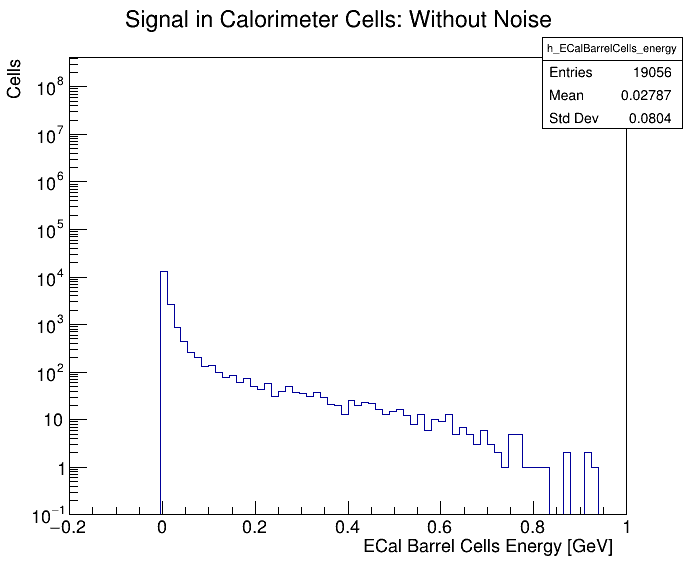

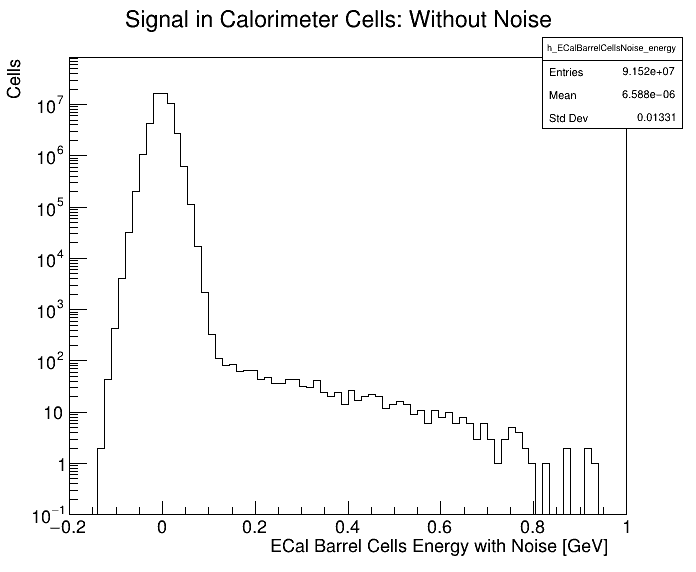

In [17]:
# histograms of the calorimeter signals in all cells with and without noise
# (zero-suppressed without noise)


import ROOT
f = ROOT.TFile("output_allCalo_reco_noise.root")
events = f.Get("events")

c = ROOT.TCanvas("c_ECalBarrelCellsNoise_energy", "", 700, 600)

h = ROOT.TH1F("h_ECalBarrelCells_energy", "Signal in Calorimeter Cells: Without Noise;ECal Barrel Cells Energy [GeV]; Cells", 80, -0.2 ,1)
events.Draw("ECalBarrelCells.core.energy >> h_ECalBarrelCells_energy", "", "")








c2 = ROOT.TCanvas("c_ECalBarrelCells_energy", "", 700, 600)
#h2 = ROOT.TH1F("h_ECalBarrelCellsNoise_energy", ";ECall Barrel Cells Energy with Noise [GeV]; Events", 80, -0.2 ,1)
h2 = h.Clone("h_ECalBarrelCellsNoise_energy")
h2.SetTitle("Signal in Calorimeter Cells: With Noise;ECal Barrel Cells Energy with Noise [GeV]; Cells")
events.Draw("ECalBarrelCellsNoise.core.energy>> h_ECalBarrelCellsNoise_energy", "", "")
h2.GetYaxis().SetRangeUser(0.1,h2.GetMaximum()*5)

h2.SetLineColor(ROOT.kBlack)


h.GetYaxis().SetRangeUser(0.1,h2.GetMaximum()*5)
c.SetLogy()
c.Draw()

c2.SetLogy()
c2.Draw()

From these plots the impact of the noise becomes clear.  Note that the branch `EcalBarrelCellsNoise` is much larger than `ECalBarrelCells`, as all cells that did not record a signal can no longer be ignored, but have to be saved as well due to the presence of noise.

### Extracting and Plotting the Resolution

The root file created by FCCSW also contains the output of the Sliding Window reconstruction in the branch "CaloClusters". Again, we first check the contents:

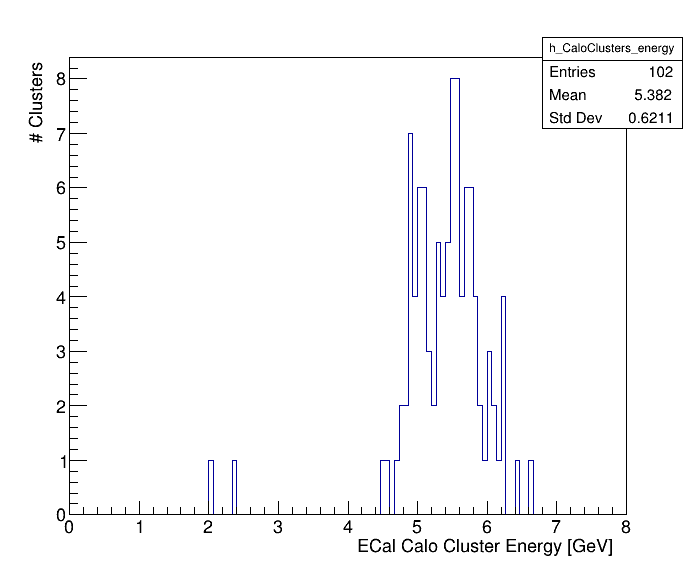

In [11]:
import ROOT
f = ROOT.TFile("output_allCalo_reco_noise.root")
events = f.Get("events")

c = ROOT.TCanvas("c_CaloClusters_energy", "", 700, 600)
hEn = ROOT.TH1F("h_CaloClusters_energy", ";ECal Calo Cluster Energy [GeV]; # Clusters", 120, 0 ,8)
events.Draw("CaloClusters.core.energy >> h_CaloClusters_energy")

c.Draw()


To extract the Calorimeter Performance, we have to fit the reco energy distribution:

mean: 5.41 [GeV]
sigma: 0.47 [GeV]


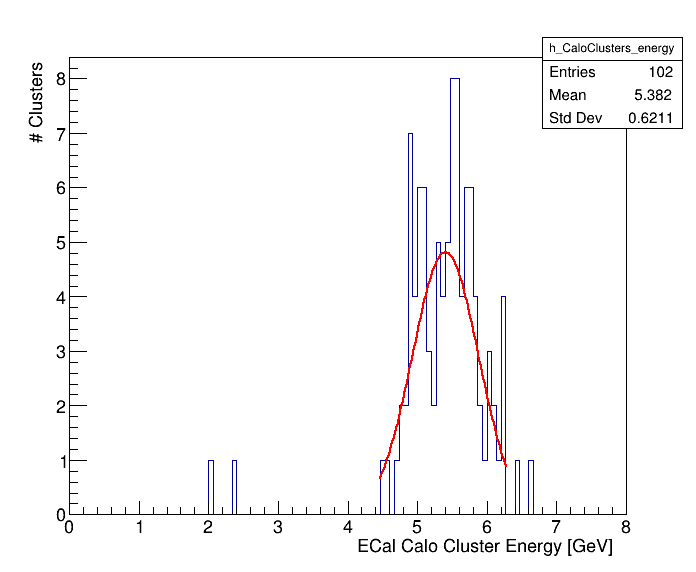

In [12]:

import ROOT
f = ROOT.TFile("output_allCalo_reco_noise.root")
events = f.Get("events")

c = ROOT.TCanvas("c_CaloClusters_energyFit", "", 700, 600)
hEn = ROOT.TH1F("h_CaloClusters_energy", ";ECal Calo Cluster Energy [GeV]; # Clusters", 120, 0 ,8)
events.Draw("CaloClusters.core.energy >> h_CaloClusters_energy")

fitPre = ROOT.TF1("fitPre","gaus", hEn.GetMean() - 1. * hEn.GetRMS(), hEn.GetMean() + 1. * hEn.GetRMS())
resultPre = hEn.Fit(fitPre, "SQRN")
fit = ROOT.TF1("fit","gaus", resultPre.Get().Parameter(1) - 2. * resultPre.Get().Parameter(2), resultPre.Get().Parameter(1) + 2. * resultPre.Get().Parameter(2))
result = hEn.Fit(fit, "SQRN")
mean = result.Get().Parameter(1)
sigma = result.Get().Parameter(2)
dMean = result.Get().Error(1)
dSigma = result.Get().Error(2)
print "mean:", round(mean,2), "[GeV]"
print "sigma:", round(sigma  ,2), "[GeV]"
fit.Draw("SAME")
c.Draw()



### Further Topics: Parametrizing the Energy Resolution 

We are of course interested in the Calorimeter response not only at one energy, but over a range of energies,
and in particular in the usual parametrisation of the resolution:



$$  {\sigma_E \over E} =  { a \over \sqrt{E}} \oplus  {b \over E} \oplus c  $$,

where a is the "stochastic term", b the "noise term" and c the "constant term" 

This requires a somewhat more complex script. The FCC Calo Group maintains one here: https://github.com/faltovaj/FCC_calo_analysis_cpp/blob/master/scripts/plot_enResolution.py

Task: Save the output of the resolution and rerun the 




### Further Topics: Calculating the Sampling Fraction and using it in Simulation

As you can see in https://github.com/HEP-FCC/FCCSW/blob/master/Reconstruction/RecFCCeeCalorimeter/options/runCaloSim.py#L112, the simulation already corrected for the sampling fraction of our calorimeter.
These values themselves are taken from simulation and in case you change the geometry they need to be recalculated and updated.

To calculate the sampling fraction, the geometry uses a trick: the whole detector can be made sensitive, so the signal that is usually "lost" can be directly accessed in the simulation. The following job options uses this special geometry:

In [25]:
%%writefile fccee_samplingfraction.py
from Gaudi.Configuration import *
import os

# Data service
from Configurables import FCCDataSvc
podioevent = FCCDataSvc("EventDataSvc")

# DD4hep geometry service
from Configurables import GeoSvc
geoservice = GeoSvc("GeoSvc", detectors=[ 
      os.path.join(os.environ.get("FCCSWBASEDIR"),'share/FCCSW/Detector/DetFCCeeIDEA-LAr/compact/FCCee_DectEmptyMaster.xml'),
      os.path.join(os.environ.get("FCCSWBASEDIR"),'share/FCCSW/Detector/DetFCCeeECalInclined/compact/FCCee_ECalBarrel_calibration.xml'),
            ],
                    OutputLevel = INFO)

# Geant4 service
# Configures the Geant simulation: geometry, physics list and user actions
from Configurables import SimG4Svc
geantservice = SimG4Svc("SimG4Svc", detector='SimG4DD4hepDetector', physicslist="SimG4FtfpBert", actions="SimG4FullSimActions")
geantservice.g4PostInitCommands += ["/run/setCut 0.1 mm"]

# Geant4 algorithm
# Translates EDM to G4Event, passes the event to G4, writes out outputs via tools
# and a tool that saves the calorimeter hits
from Configurables import SimG4Alg, SimG4SaveCalHits, SimG4SingleParticleGeneratorTool
saveecaltool = SimG4SaveCalHits("saveECalBarrelHits",readoutNames = ["ECalBarrelEta"])
saveecaltool.positionedCaloHits.Path = "ECalBarrelPositionedHits"
saveecaltool.caloHits.Path = "ECalBarrelHits"
from Configurables import SimG4SingleParticleGeneratorTool
pgun=SimG4SingleParticleGeneratorTool("SimG4SingleParticleGeneratorTool",saveEdm=True,
                                      particleName = "e-", energyMin = 50000, energyMax = 50000, etaMin = 0, etaMax = 0,
                                      OutputLevel = DEBUG)
# next, create the G4 algorithm, giving the list of names of tools ("XX/YY")
geantsim = SimG4Alg("SimG4Alg",
                    outputs= ["SimG4SaveCalHits/saveECalBarrelHits"],
                    eventProvider = pgun,
                    OutputLevel = DEBUG)

from Configurables import SamplingFractionInLayers
hist = SamplingFractionInLayers("hists",
                                 energyAxis = 50,
                                 readoutName = "ECalBarrelEta",
                                 layerFieldName = "layer",
                                 activeFieldName = "type",
                                 activeFieldValue = 0,
                                 numLayers = 8,
                                 OutputLevel = INFO)
hist.deposits.Path="ECalBarrelPositionedHits"

THistSvc().Output = ["rec DATAFILE='histSF_fccee_inclined_e50GeV_eta0_1events.root' TYP='ROOT' OPT='RECREATE'"]
THistSvc().PrintAll=True
THistSvc().AutoSave=True
THistSvc().AutoFlush=False
THistSvc().OutputLevel=INFO

#CPU information
from Configurables import AuditorSvc, ChronoAuditor
chra = ChronoAuditor()
audsvc = AuditorSvc()
audsvc.Auditors = [chra]
geantsim.AuditExecute = True
hist.AuditExecute = True

from Configurables import PodioOutput
### PODIO algorithm
out = PodioOutput("out",OutputLevel=DEBUG)
out.outputCommands = ["keep *"]
out.filename = "fccee_samplingFraction_inclinedEcal.root"

# ApplicationMgr
from Configurables import ApplicationMgr
ApplicationMgr( TopAlg = [geantsim, hist, out],
                EvtSel = 'NONE',
                EvtMax = 50,
                # order is important, as GeoSvc is needed by G4SimSvc
                ExtSvc = [podioevent, geoservice, geantservice, audsvc],
                OutputLevel = DEBUG
)


Overwriting fccee_samplingfraction.py


In [26]:
!fccrun fccee_samplingfraction.py

 -->  SimG4Alg  -->  hists  -->  out  

JobOptionsSvc       DEBUG Service base class initialized successfully
MessageSvc          DEBUG Service base class initialized successfully
ApplicationMgr      DEBUG Getting my own properties
ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v32r0)
                                          running on 74d76f9a8ce0 on Wed Oct  2 19:05:59 2019
ApplicationMgr      DEBUG Loading declared DLL's

**************************************************************
 Geant4 version Name: geant4-10-05-patch-01 [MT]   (17-April-2019)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

Applicatio

Geant4Converter  INFO  +++  Successfully converted geometry to Geant4.
DD4hepVolumeManager INFO  **** running plugin DD4hepVolumeManager ! 
VolumeManager    INFO   - populating volume ids - be patient ...
VolumeManager    INFO   - populating volume ids - done. 89096 nodes.
VolumeManager    INFO  +++ Volume manager populated and loaded.

 FTFP_BERT : new threshold between BERT and FTFP is over the interval 
 for pions :   3 to 12 GeV
 for kaons :   3 to 12 GeV
 for proton :  3 to 12 GeV
 for neutron : 3 to 12 GeV

### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0
SimG4Svc             INFO Random numbers seeds: 1234567	115259296

phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bi


hIoni:  for kaon-  SubType=2
      dE/dx and range tables from 100 eV  to 100 TeV in 84 bins
      Lambda tables from threshold to 100 TeV, 7 bins/decade, spline: 1
      StepFunction=(0.2, 0.1 mm), integ: 1, fluct: 1, linLossLim= 0.01
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
            ICRU73QO : Emin=    0 eV  Emax=1.05231 MeV
          BetheBloch : Emin=1.05231 MeV Emax=  100 TeV

hBrems:  for kaon-  SubType=3
      dE/dx and range tables from 100 eV  to 100 TeV in 84 bins
      Lambda tables from threshold to 100 TeV, 7 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
               hBrem : Emin=    0 eV  Emax=  100 TeV

hPairProd:  for kaon-  SubType=4
      dE/dx and range tables from 100 eV  to 100 TeV in 84 bins
      Lambda tables from threshold to 100 TeV, 7 bins/decade, spline: 1
      Sampling table 18x1001; from 3.94942 GeV to 100 TeV 
      ===== EM models for the G4Region  DefaultRegionForTheW

ServiceManager      DEBUG Initializing service AuditorSvc
AuditorSvc          DEBUG Service base class initialized successfully
ChronoStatSvc       DEBUG Service base class initialized successfully
ServiceManager      DEBUG Initializing service AppMgrRunable
AppMgrRunable       DEBUG Service base class initialized successfully
ServiceManager      DEBUG Initializing service EventLoopMgr
EventLoopMgr        DEBUG Service base class initialized successfully
IncidentSvc         DEBUG Adding [AbortEvent] listener '<unknown>' with priority 0
EventLoopMgr        DEBUG Creating Top Algorithm SimG4Alg with name SimG4Alg
EventLoopMgr        DEBUG Creating Top Algorithm SamplingFractionInLayers with name hists
EventLoopMgr        DEBUG Creating Top Algorithm PodioOutput with name out
AlgContextSvc       DEBUG Service base class initialized successfully
IncidentSvc         DEBUG Adding [BeginEvent] listener 'AlgContextSvc' with priority 0
IncidentSvc         DEBUG Adding [EndEvent] listener 'AlgCo

RootFileHandler     DEBUG opened TFile 0xb8c0d70 Fd: 4
FileMgr             DEBUG opened file name: "histSF_fccee_inclined_e50GeV_eta0_1events.root"  tech: ROOT  desc: HIST  flags: WRITE|CREATE  i_flags: WRITE|CREATE  Fd: 4  ptr: 0xb8c0d70  [o] [u]
FileMgr             DEBUG executing 1 OPEN actions on name: "histSF_fccee_inclined_e50GeV_eta0_1events.root"  tech: ROOT  desc: HIST  flags: WRITE|CREATE  i_flags: WRITE|CREATE  Fd: 4  ptr: 0xb8c0d70  [o] [u] from THistSvc
FileMgr             DEBUG executing THistSvc::initialize()::{lambda(Io::FileAttr const*,std::string const&)#1}
IoComponentMgr      DEBUG --> initialize()
IoComponentMgr      DEBUG Service base class initialized successfully
IncidentSvc         DEBUG Adding [BeginOutputFile] listener 'IoComponentMgr' with priority 100
IncidentSvc         DEBUG Adding [BeginInputFile] listener 'IoComponentMgr' with priority 100
IoComponentMgr      DEBUG --> io_register(THistSvc)
IoComponentMgr      DEBUG     registering IoComponent "THistSvc"

ToolSvc.saveECa...  DEBUG 	440468 hits are stored in a collection #0: ECalBarrelEta
out                 DEBUG Filling DataTree ..
SimG4Alg.SimG4S...  DEBUG particle definition 0x5fda010 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 50000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0 2.26356
ToolSvc.saveECa...  DEBUG 	435326 hits are stored in a collection #0: ECalBarrelEta
out                 DEBUG Filling DataTree ..
SimG4Alg.SimG4S...  DEBUG particle definition 0x5fda010 +++  'particleName':e-
SimG4Alg.SimG4S...  DEBUG particle mass = 0.510999
SimG4Alg.SimG4S...  DEBUG particle energy = 50000
SimG4Alg.SimG4S...  DEBUG particle eta, phi  = 0 2.72807
ToolSvc.saveECa...  DEBUG 	438966 hits are stored in a collection #0: ECalBarrelEta
out                 DEBUG Filling DataTree ..
EventLoopMgr        DEBUG ---> Loop Finished -  WSS 426.879 | total time (skipping 1st evt) 19014302751 ns
ServiceManager      DEBUG Sto

ServiceManager      DEBUG Finalizing service HistogramPersistencySvc
ServiceManager      DEBUG Finalizing service ChronoStatSvc
*****Chrono*****     INFO ****************************************************************************************************
*****Chrono*****     INFO  The Final CPU consumption ( Chrono ) Table (ordered)
*****Chrono*****     INFO ****************************************************************************************************
hists:Execute        INFO Time User   : Tot=  170 [ms] Ave/Min/Max=   34(+-  4.9)/   30/   40 [ms] #=  5
SimG4Alg:Execute     INFO Time User   : Tot= 19.7  [s] Ave/Min/Max= 3.94(+-0.155)/ 3.71/ 4.13  [s] #=  5
ChronoStatSvc        INFO Time User   : Tot= 23.3  [s]                                             #=  1
*****Chrono*****     INFO ****************************************************************************************************
ChronoStatSvc.f...   INFO  Service finalized successfully 
ServiceManager      DEBUG Finalizing 

Now the sampling fraction can be extracted from each layer. Take a look at https://github.com/faltovaj/FCC_calo_analysis_cpp/blob/master/scripts/plot_samplingFraction.py to check how this can be done.